# BERTtopic

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import pickle
from src.data.preprocess import Preprocessor

In [2]:
data = pd.read_csv("../../data/raw/reviews.csv", parse_dates=['Time'])
preprocessor = Preprocessor(data)
preprocessor.clean_csv()
pre_processed_df = preprocessor.clean_df

## Prepare model

### Prepare embeddings

In [3]:
# # Prepare embeddings
# sentence_model = SentenceTransformer("all-MiniLM-L12-v2")
# embeddings = sentence_model.encode(pre_processed_df['cleaned_text'], show_progress_bar=True)

In [4]:
# # save embeddings
# with open('BERTopic_embeddings.pickle', 'wb') as pkl:
#     pickle.dump(embeddings, pkl)

In [19]:
# Load embeddings
with open('../../data/embeddings/BERTopic_embeddings.pickle', 'rb') as pkl:
    embeddings = pickle.load(pkl)

### UMAP for dimensionality reduction

In [20]:
umap_model = UMAP(n_neighbors=100, 
                  n_components=3, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=4263)

### HDBSCAN for clustering

In [21]:
hdbscan_model = HDBSCAN(min_cluster_size=50,
                        min_samples=20,
                        metric='euclidean',
                        prediction_data = True)

### Initialize BERTopic

Setting `nr_topics='auto'` will run the HDBSCAN we have made to cluster and reduce the number of topics

In [22]:
# Initiate BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       language="english",
                       calculate_probabilities=True,
                       nr_topics="auto")

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(pre_processed_df['cleaned_text'], embeddings)

## Evaluate model

In [18]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                              Name
0      -1   1954               -1_not_taste_my_but
1       0    491            0_coffee_cup_not_taste
2       1    403         1_sauce_soup_noodle_pasta
3       2    399           2_price_box_product_not
4       3    344             3_tea_green_taste_not
5       4    232               4_dog_treat_food_my
6       5    221            5_gluten_cake_free_mix
7       6    211         6_drink_orange_juice_soda
8       7    192              7_snack_baby_my_love
9       8    117         8_chocolate_hot_cocoa_not
10      9    112          9_bar_snack_protein_like
11     10    112         10_chip_bag_kettle_potato
12     11     98           11_salt_jerky_sea_table
13     12     95       12_peanut_butter_almond_nut
14     13     84     13_sugar_stevia_sweetener_use
15     14     74               14_cat_food_she_eat
16     15     68       15_cereal_fiber_eat_healthy
17     16     67           16_taste_not_good_great
18     17     65       17_cookie_oatmeal_cooky_oat
19     18     54         18_popcorn_pop_oil_popper
20     19     51  19_coconut_water_syrup_pineapple

In [23]:
# Get top 10 terms for a topic
topic_model.get_topic(2)

[('price', 0.036529072164751646),
 ('box', 0.030241002983214277),
 ('product', 0.02979935355639935),
 ('not', 0.02866442597552161),
 ('candy', 0.028270769678430303),
 ('order', 0.028126900174134724),
 ('buy', 0.026924495883878477),
 ('store', 0.023921493664076563),
 ('get', 0.023841776818965266),
 ('package', 0.022899649733983903)]

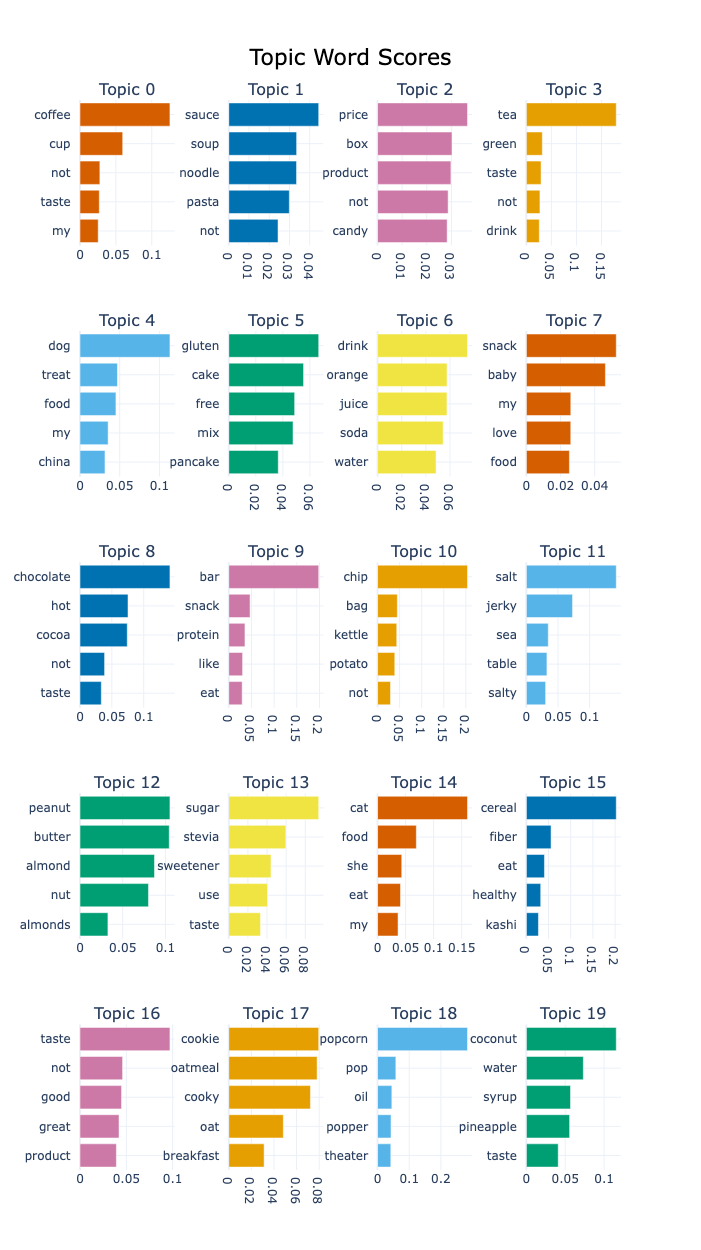

In [24]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=20)

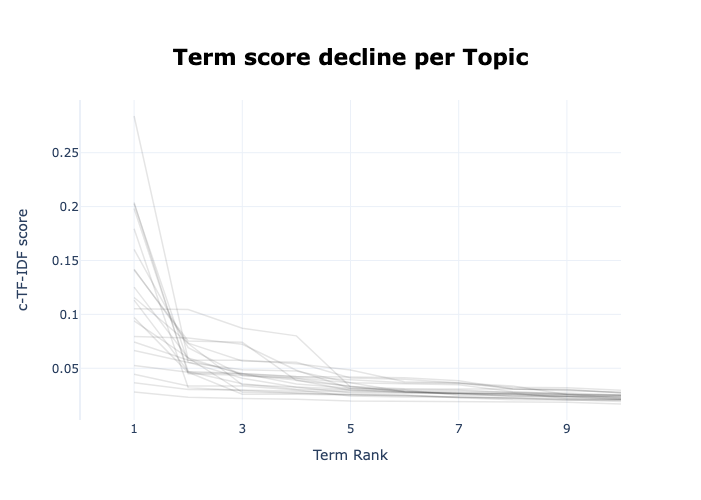

In [25]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

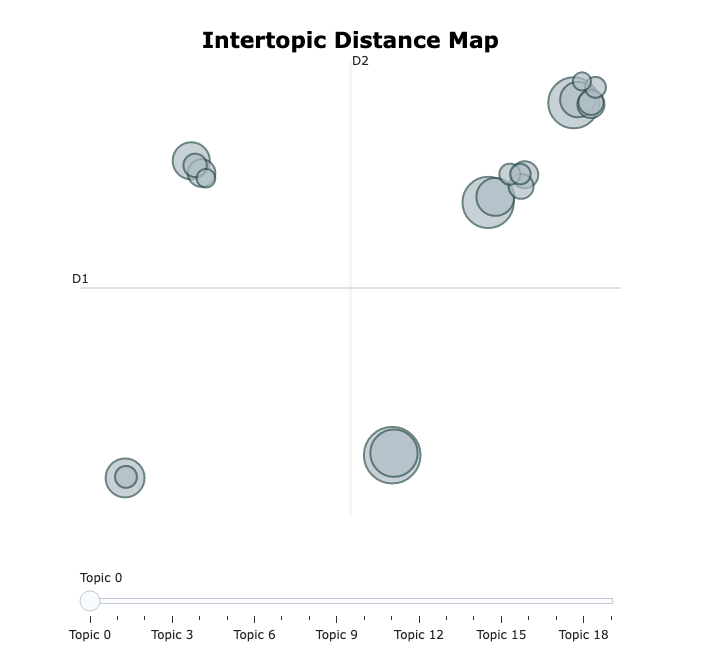

In [26]:
# Visualize intertopic distance
topic_model.visualize_topics()

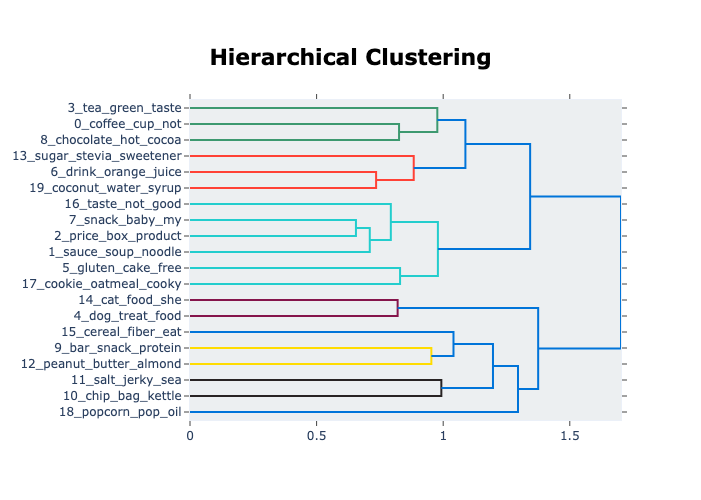

In [27]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=20)

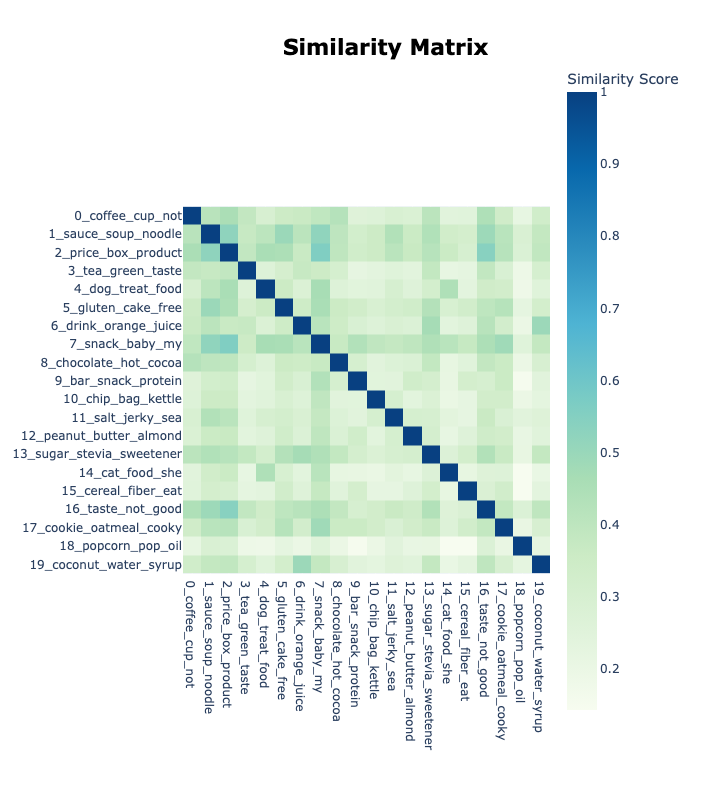

In [28]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

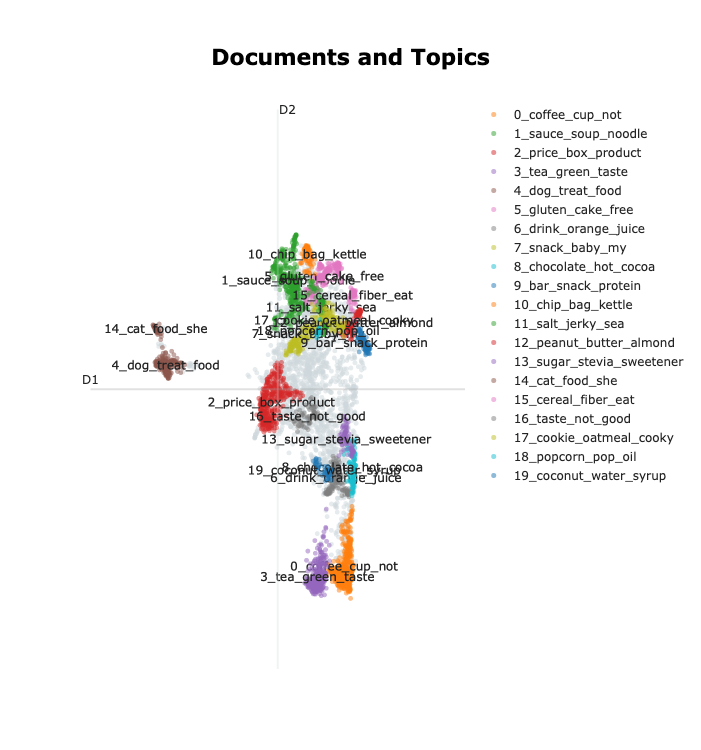

In [29]:
topic_model.visualize_documents(pre_processed_df["cleaned_text"], reduced_embeddings=umap_model.fit_transform(embeddings))

### Topics over time

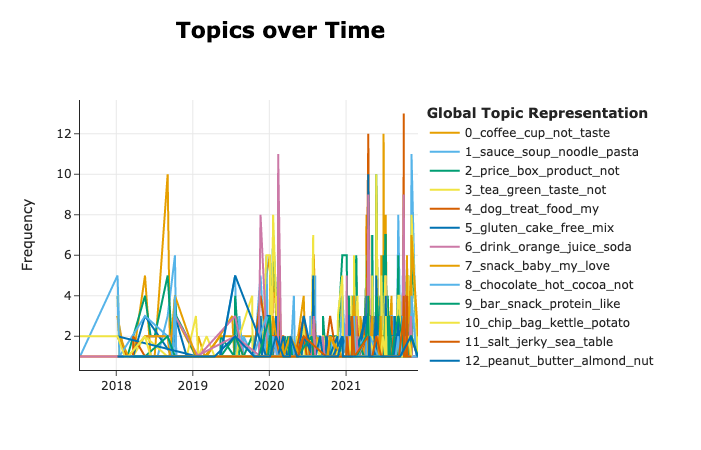

In [30]:
topics_over_time = topic_model.topics_over_time(pre_processed_df["cleaned_text"], pre_processed_df["time"])
topic_model.visualize_topics_over_time(topics_over_time)

### Topics by sentiment

In [31]:
sentiment = [i for i in pre_processed_df["sentiment"]]

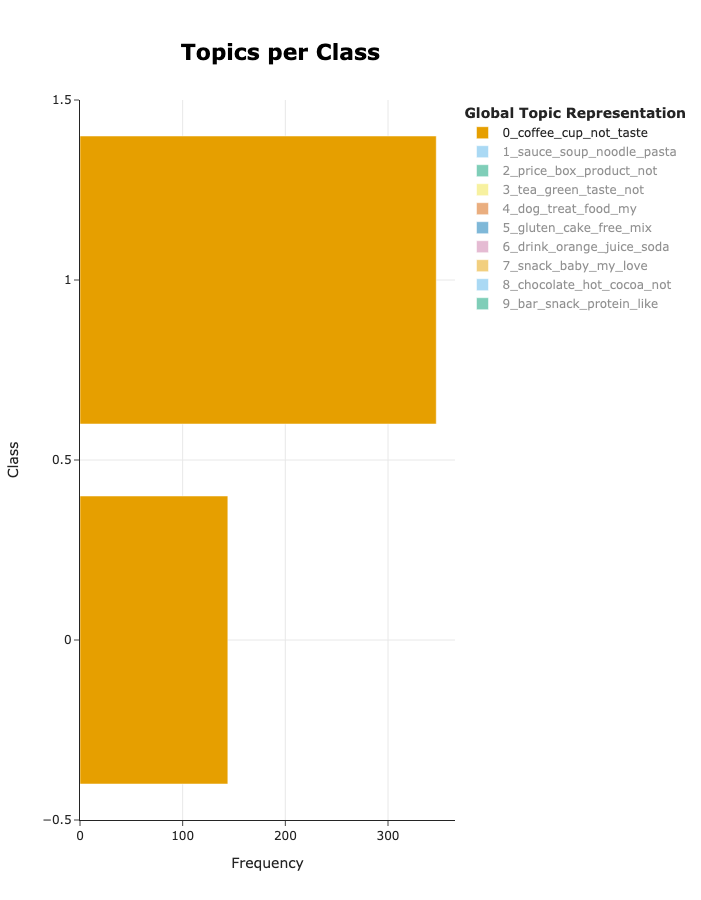

In [32]:
topics_by_sentiment = topic_model.topics_per_class(pre_processed_df["cleaned_text"], classes=sentiment)
topic_model.visualize_topics_per_class(topics_by_sentiment)

In [33]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(pre_processed_df["cleaned_text"], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(pre_processed_df["cleaned_text"][5000], topic_token_distr[5000])
df

## Append topic to dataset

In [34]:
# Get the topic predictions
topic_prediction = topic_model.topics_[:]
# Save the predictions in the dataframe
pre_processed_df['topic_id'] = topic_prediction

In [35]:
topics_dict = topic_model.get_topics()
topics_df = pd.DataFrame()
for topic_id, topic in topics_dict.items():
    topic_df = pd.DataFrame(topic, columns=['word', 'weight'])
    topic_df['topic_id'] = topic_id
    topics_df = pd.concat([topics_df, topic_df], ignore_index=True)
topics_df

word    weight  topic_id
0       not  0.028020        -1
1     taste  0.023138        -1
2        my  0.021959        -1
3       but  0.021287        -1
4      like  0.019599        -1
..      ...       ...       ...
205   drink  0.039803        19
206  bottle  0.036422        19
207     not  0.033562        19
208   maple  0.025695        19
209  splash  0.024933        19

[210 rows x 3 columns]

In [36]:
data_df = pre_processed_df.merge(topics_df, on='topic_id')

In [37]:
pivoted_df = data_df.pivot_table(index=['sentiment', 'time','text', 'cleaned_text','topic_id'],
                                 columns=data_df.groupby(['sentiment', 'time','text', 'cleaned_text', 'topic_id']).cumcount() + 1,
                                 values=['word', 'weight'],
                                aggfunc = 'first').reset_index()
# Flatten the column names
pivoted_df.columns = ['_'.join(map(str, col)).strip() for col in pivoted_df.columns.values]

# # Rename the columns
pivoted_df = pivoted_df.rename(columns={'sentiment_': 'sentiment', 'time_': 'time', 'text_': 'text','cleaned_text_':'cleaned_text', 'topic_id_': 'topic_id'})

column_order = ['sentiment', 'time', 'text', 'cleaned_text', 'topic_id']

for i in range(1, len(pivoted_df.columns[5:]), 2):
    column_order += [f'word_{i//2+1}', f'weight_{i//2+1}']

pivoted_df = pivoted_df.reindex(columns=column_order)

# Ensure same order as original df
data2 = pre_processed_df.set_index(["sentiment","time","text","cleaned_text"])
pivoted_df2 = pivoted_df.set_index(["sentiment","time","text","cleaned_text"])
output = pivoted_df2.reindex(data2.index).reset_index()
#output.to_csv("../../data/processed/clean_reviews_w_topics.csv", index = False)

In [38]:
output

sentiment       time                                               text  \
0             1 2021-06-18  This is a very healthy dog food. Good for thei...   
1             1 2021-07-07  I've been very pleased with the Natural Balanc...   
2             1 2021-06-18  Before I was educated about feline nutrition, ...   
3             1 2021-07-07  My holistic vet recommended this, along with a...   
4             1 2021-01-07  I bought this coffee because its much cheaper ...   
...         ...        ...                                                ...   
5439          0 2021-02-26  This is an okay gift box, only if you like med...   
5440          0 2019-12-18  It looks llike I just walked into a raw deal. ...   
5441          0 2020-01-19  Thank god that i tasted the metal before i swa...   
5442          0 2020-09-13  This product was very good when I began buying...   
5443          0 2020-10-07  Once again, Paragon has disappointed with this...   

                                           cleaned_text  topic_id  word_1  \
0     very healthy dog food good digestion good smal...         4     dog   
1     very pleased natural balance dog food our dog ...         4     dog   
2     educate feline nutrition allow my cat become a...        14     cat   
3     my holistic vet recommend brand try but my cat...        14     cat   
4     buy coffee because much cheap than ganocafe or...         0  coffee   
...                                                 ...       ...     ...   
5439  okay gift box only like mediocre cheese summer...         2   price   
5440  look llike walked raw deal item intolerably st...        -1     not   
5441  thank god taste metal swallow not even get get...        -1     not   
5442  product very good begin buy but lately terribl...        16   taste   
5443  again paragon disappoint flavor hawaiian tropi...        -1     not   

      weight_1 word_2  weight_2   word_3  ...   word_6  weight_6   word_7  \
0     0.113213  treat  0.047125     food  ...      pet  0.029852      she   
1     0.113213  treat  0.047125     food  ...      pet  0.029852      she   
2     0.160373   food  0.069144      she  ...  science  0.028277  felidae   
3     0.160373   food  0.069144      she  ...  science  0.028277  felidae   
4     0.125342    cup  0.059497      not  ...    roast  0.024339   flavor   
...        ...    ...       ...      ...  ...      ...       ...      ...   
5439  0.036529    box  0.030241  product  ...    order  0.028127      buy   
5440  0.028020  taste  0.023138       my  ...    great  0.019227     good   
5441  0.028020  taste  0.023138       my  ...    great  0.019227     good   
5442  0.097078    not  0.045965     good  ...      buy  0.036695   flavor   
5443  0.028020  taste  0.023138       my  ...    great  0.019227     good   

      weight_7   word_8  weight_8   word_9  weight_9  word_10 weight_10  
0     0.025087      not  0.024694  product  0.023740     make  0.021428  
1     0.025087      not  0.024694  product  0.023740     make  0.021428  
2     0.026809    grain  0.025848     diet  0.024134      not  0.024131  
3     0.026809    grain  0.025848     diet  0.024134      not  0.024131  
4     0.023310      but  0.022369     like  0.022214   keurig  0.021427  
...        ...      ...       ...      ...       ...      ...       ...  
5439  0.026924    store  0.023921      get  0.023842  package  0.022900  
5440  0.019200  product  0.018608   flavor  0.018452     very  0.016882  
5441  0.019200  product  0.018608   flavor  0.018452     very  0.016882  
5442  0.035875      but  0.032458    price  0.031981     very  0.029681  
5443  0.019200  product  0.018608   flavor  0.018452     very  0.016882  

[5444 rows x 25 columns]